# Object Detection Fundamentals

## Initialization

In [1]:
# Install required libraries
!pip install selectivesearch
!pip install torch_snippets

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=afea7f608e4b3c554344f7969a634f1bda5176f50fd00f0b0a3f07736c3ec045
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Load libraries

# OS
import os

# Data manipulation, visualization and model building
from torchvision import models
from torchvision.ops import RoIPool, nms
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb
from google.colab import files
!nvidia-smi # check if GPU is available
%matplotlib inline

Mon Feb 26 00:42:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download a sample image
root_dir = 'data/'
!wget https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg -P {root_dir}
image = read(f'{root_dir}/Hemanvi.jpeg', 1)

--2024-02-26 00:42:50--  https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l98leemr7r5stnm/Hemanvi.jpeg [following]
--2024-02-26 00:42:51--  https://www.dropbox.com/s/raw/l98leemr7r5stnm/Hemanvi.jpeg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6d4df1072b88b0624a28c620a.dl.dropboxusercontent.com/cd/0/inline/CN-7kMJiDh_FZ12lN3AorC7UC5GC-XFJG6X6GwTinJ0YrR305AQSGk8ibOP25bnkeApxfMiuh4sPkqjF9I-c9oD5zUO5KELakj27kjcIlhYxd0S6in2XrQ4-A7tkIc7PBs5XOYynT-3wc_gs2uN3e-x_/file# [following]
--2024-02-26 00:42:51--  https://ucf6d4df1072b88b0624a28c620a.dl.dropboxusercontent.com/cd/0/inline/CN-7kMJiDh_FZ12lN3AorC7UC5GC-XFJG6X6GwTinJ0YrR305AQSGk8ibOP25bnkeApxfMiuh4sPkqjF9I-c9oD5zUO5KELakj27kj

## Generate region proposals using SelectiveSearch

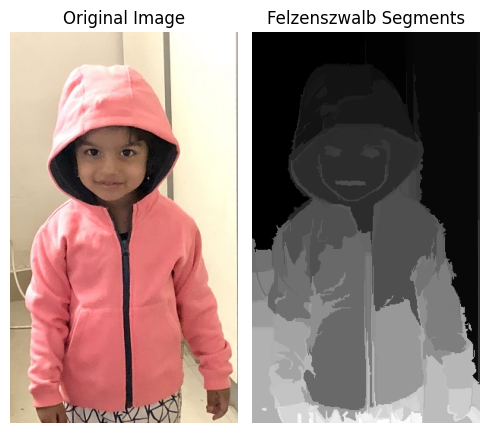

In [5]:
# Extract felzenszwalb segments
segments_fz = felzenszwalb(image, scale=200) # scale: Higher means larger segments

# Display the segments
subplots([image, segments_fz], titles=['Original Image', 'Felzenszwalb Segments'], nc=2, sz=5)

In [6]:
# Create function to extract selective search segments
def extract_candidates(image):
    # Perform selective search to extract region proposals
    _, regions = selectivesearch.selective_search(image, scale=200, min_size=100)
    image_area = np.prod(image.shape[:2])
    candidates = []
    for region in regions:
        # Exclude duplicates
        if region['rect'] in candidates:
            continue
        # Exclude very small regions
        if region['size'] < (0.05 * image_area):
            continue
        # Exclude very large regions
        if region['size'] > (1 * image_area):
            continue
        # Extract width and height and exclude empty regions
        _, _, w, h = region['rect']
        if w == 0 or h == 0:
            continue
        # Append the region to candidates
        candidates.append(list(region['rect']))
    return candidates

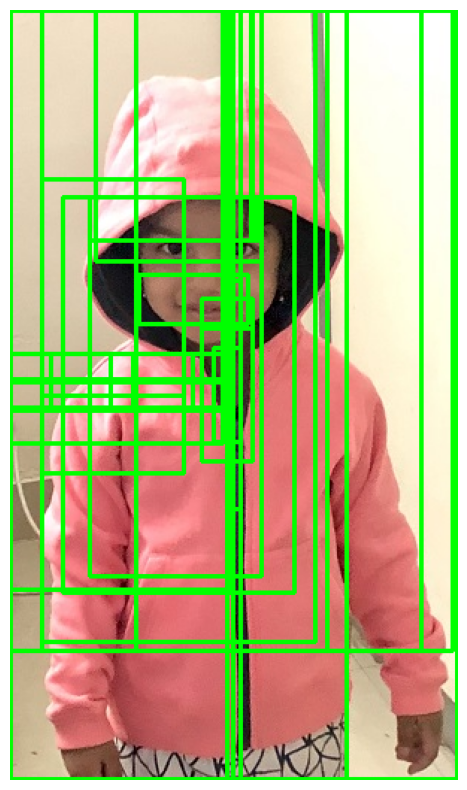

In [7]:
# Extract selective search segments
candidates = extract_candidates(image)

# Display the segments
show(image, bbs=candidates, sz=10)

## Intersection over Union (IoU)

<table>
    <tbody>
        <tr>
            <td>
                <img src="intersection_over_union.png" alt="Intersection over Union (IoU)" width="400">
            </td>
        </tr>
        <tr>
            <td>
                <img src="iou_sample_scores.png" alt="Intersection over Union score samples" width="400">
            </td>
        </tr>
    </tbody>
</table>

In [8]:
# Create a fucntion to calculate the IoU
# boxA and boxB are in the format [x1, y1, x2, y2] and epsilon is a small value to avoid division by zero
def calculate_iou(boxA, boxB, epsilon=1e-5):
    # Determine the coordinates of the intersection rectangle
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    # Calculate the intersection rectangle area (Overlapping Area)
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0): # If the width or height is negative, then the intersection area is 0
        return 0.0
    area_overlap = width * height

    # Calculate the area of both rectangles
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Calculate the combined area
    area_combined = area_a + area_b - area_overlap

    # Calculate the IoU
    return area_overlap / (area_combined + epsilon)

## R-CNN-based custom object detector (Region-based CNN)
<table>
    <tbody>
        <tr>
            <td>
                <img src="r-cnn.png" alt="R-CNN" height="300">
            </td>
        </tr>
    </tbody>
</table>

In [9]:
# Upload Kaggle Token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keneth4","key":"c0c016311b74b86d99e3984089fbd3b3"}'}

In [10]:
# Copy Kaggle Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [11]:
# Download and unzip Bus Trucks dataset from Kaggle
!kaggle datasets download -d sixhky/open-images-bus-trucks
!unzip -qq open-images-bus-trucks.zip -d data
!ls

 98% 361M/367M [00:03<00:00, 143MB/s]
100% 367M/367M [00:03<00:00, 103MB/s]
data  kaggle.json  open-images-bus-trucks.zip  sample_data


In [12]:
# Get the list of images
root_dir = '/content/data/'
dataset_df = pd.read_csv(f'{root_dir}/df.csv')
print(dataset_df.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [13]:
# Create Dataset class to fetch images and labels
class OpenImages(Dataset):
    def __init__(self, df, image_folder=f'{root_dir}/images/images'):
        self.root_dir = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self): return len(self.unique_images)

    def __getitem__(self, idx):
        # Get the image id and path
        image_id = self.unique_images[idx]
        image_path = f'{self.root_dir}/{image_id}.jpg'

        # Read the image and get the bounding boxes and classes
        image = read(image_path, 1)
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        bboxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        bboxes = (bboxes * np.array([w, h, w, h])).astype(np.uint16).tolist() # Rescale the bounding boxes to the image size
        classes = df['LabelName'].values.tolist()
        return image, bboxes, classes, image_path

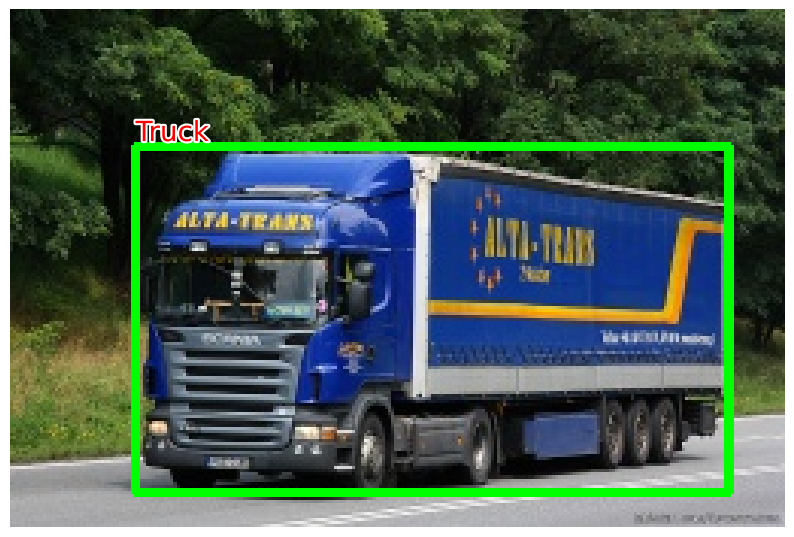

In [14]:
# Plot a sample image
ds = OpenImages(df=dataset_df)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, text_sz=20, sz=10)

In [15]:
# Prepare the data for training (Fetch region proposals and ground truth offsets)
open_images_ds = OpenImages(df=dataset_df)

file_paths = [] # File paths
gt_bbs = [] # Ground truth bounding boxes
classes = [] # Class labels
deltas = [] # Offsets
rois = [] # Region proposals (Region of Interest - RoI)
ious = [] # IoU (Intersection over Union)

total_images = 500 # Number of images to process
for it_1, (image, bbs, labels, file_path) in enumerate(open_images_ds):
    if(it_1==total_images):
        break

    # Extract region proposals (candidates) using selective search
    candidates = extract_candidates(image)

    # Convert the candidates to the format [x1, y1, x2, y2] (bounding box format) instead of [x, y, w, h]
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

    # Initialize lists to store the results
    _classes, _deltas, _rois= [], [], []

    # For each candidate, calculate the IoU with all ground truth bounding boxes and store the results in a 2D array
    _ious = np.array([[calculate_iou(candidate, bb) for bb in bbs] for candidate in candidates])

    # For each candidate, find the best bounding box and calculate the offset (delta)
    h, w, _ = image.shape
    for it_1_1, candidate in enumerate(candidates):
        # Filter the IoU array to get the IoU values for the current candidate
        candidate_ious = _ious[it_1_1]

        # Get the id of the bbox with the highest IoU
        best_iou_id = np.argmax(candidate_ious)

        # Get the best IoU and the best bounding box
        best_iou = candidate_ious[best_iou_id]
        best_bb = bbs[best_iou_id]

        # If the best IoU is greater than 0.3 (threshold), assign the class label to the candidate, else assign 'background'
        if best_iou > 0.3:
            _classes.append(labels[best_iou_id])
        else :
            _classes.append('background')

        # Calculate the offsets (deltas), how much the candidate bounding box differs from the best bounding box (ground truth bounding box)
        delta = np.array(best_bb) - np.array(candidate) # Calculate the delta (broadcasting is used)
        _deltas.append(delta / np.array([w, h, w, h])) # Normalize the delta by the image size and save it
        _rois.append(candidate / np.array([w, h, w, h])) # Normalize candidate bounding box by image size and save it

    # Append the results to the lists
    file_paths.append(file_path)
    gt_bbs.append(bbs)
    classes.append(_classes)
    deltas.append(_deltas)
    rois.append(_rois)
    ious.append(_ious)

# Format file paths
file_paths = [f'{root_dir}/images/images/{stem(f)}.jpg' for f in file_paths]

In [16]:
# Assign indices to the classes
targets = pd.DataFrame(flatten(classes), columns=['label'])
label2target = {label:target for target, label in enumerate(targets['label'].unique())}
target2label = {target:label for label, target in label2target.items()}
background_class = label2target['background']

In [17]:
# Create a function to preprocess images
def preprocess_image(image):
    image = torch.tensor(image).permute(2,0,1)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet mean and standard deviation
    image = transform(image)
    return image.to(device).float()

# Create a function to decode predictions
def decode_pred(_y):
    _, preds = _y.max(-1)
    return preds

In [18]:
# Create Dataset class for Region-based Convolutional Neural Network (R-CNN)
class RCNNDataset(Dataset):
    def __init__(self, file_paths, rois, labels, deltas, gt_bbs):
        self.file_paths = file_paths
        self.gt_bbs = gt_bbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = str(self.file_paths[idx])
        image = read(file_path, 1)
        gt_bbs = self.gt_bbs[idx]
        rois = self.rois[idx]
        h, w, _ = image.shape
        bbs = (np.array(rois) * np.array([w, h, w, h])).astype(np.uint16) # Rescale the bounding boxes to the image size
        labels = self.labels[idx]
        deltas = self.deltas[idx]
        crops = [image[y1:y2, x1:x2] for (x1, y1, x2, y2) in bbs]
        return image, crops, bbs, labels, deltas, gt_bbs, file_path

    def collate_fn(self, batch):
        crops, labels, deltas = [], [], []
        for idx in range(len(batch)):
            _, image_crops, _, image_labels, image_deltas, _, _ = batch[idx]
            image_crops = [cv2.resize(crop, (224, 224)) for crop in image_crops]
            image_crops = [preprocess_image(crop / 255.)[None] for crop in image_crops]
            crops.extend(image_crops)
            labels.extend([label2target[label] for label in image_labels])
            deltas.extend(image_deltas)
        crops = torch.cat(crops).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(np.array(deltas)).float().to(device)
        return crops, labels, deltas

In [19]:
# Get the train limit
n_train = 9 * len(file_paths) // 10 # 90% of the data for training

# Create the train and validation datasets
train_ds = RCNNDataset(file_paths[:n_train], rois[:n_train], classes[:n_train], deltas[:n_train], gt_bbs[:n_train])
val_ds = RCNNDataset(file_paths[n_train:], rois[n_train:], classes[n_train:], deltas[n_train:], gt_bbs[n_train:])

In [20]:
# Create a function to retrieve the dataloaders
def load_data(batch_size = 2):
    train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)
    return train_dl, val_dl

In [21]:
# Define a VGG16 backbone
vgg_backbone = models.vgg16(weights='IMAGENET1K_V1')
vgg_backbone.classifier = nn.Sequential() # Remove the fully connected layers
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# Create a class for the Region-based Convolutional Neural Network (R-CNN) model
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088 # VGG16 backbone output size (512 * 7 * 7)
        self.backbone = vgg_backbone
        self.class_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh(),
        )
        self.ce_loss = nn.CrossEntropyLoss()
        self.l1_loss = nn.L1Loss()
        self._lamba = 10.0 # Lambda for the regression loss

    def forward(self, x):
        features = self.backbone(x)
        class_score = self.class_score(features)
        bbox = self.bbox(features)
        return class_score, bbox # Return the class scores and the bounding box offsets (p_labels, p_deltas)

    def calc_loss(self, p_labels, p_deltas, labels, deltas):
        detection_loss = self.ce_loss(p_labels, labels)
        idxs, = torch.where(labels != background_class)
        p_deltas = p_deltas[idxs]
        deltas = deltas[idxs]
        if len(idxs) > 0:
            regression_loss = self.l1_loss(p_deltas, deltas)
            return detection_loss + self._lamba * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self._lamba * regression_loss, detection_loss.detach(), regression_loss

In [23]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    crops, classes, deltas = data
    p_labels, p_deltas = model(crops)
    loss, detection_loss, regression_loss = criterion(p_labels, p_deltas, classes, deltas)
    accuracies = classes == decode_pred(p_labels)
    loss.backward()
    optimizer.step()
    return loss.detach(), detection_loss, regression_loss, accuracies.cpu().numpy()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    crops, classes, deltas = data
    p_labels, p_deltas = model(crops)
    loss, detection_loss, regression_loss = criterion(p_labels, p_deltas, classes, deltas)
    accuracies = classes == decode_pred(p_labels)
    return p_labels, p_deltas, loss.detach(), detection_loss, regression_loss, accuracies.cpu().numpy()

EPOCH: 5.000  val_loss: 1.650  val_detection_loss: 0.597  val_regression_loss: 0.105  val_acc: 0.740  (730.67s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 3795.26it/s]


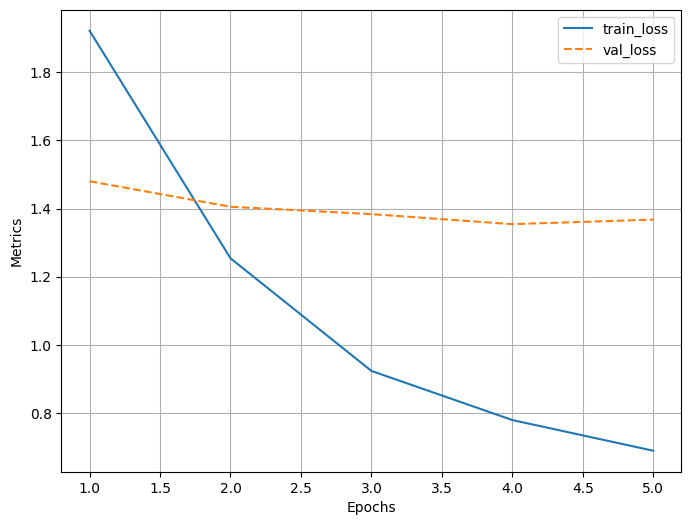

In [24]:
# Train the model
model = RCNN().to(device)
critertion = model.calc_loss
optimizer = optim.SGD(model.parameters(), lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, detection_loss, regression_loss, accs = train_batch(model, data, critertion, optimizer)
        log.record(
            epoch+(i+1)/n,
            train_loss=loss.item(),
            train_detection_loss=detection_loss,
            train_regression_loss=regression_loss,
            train_acc=accs.mean(),
            end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        p_labels, p_deltas, loss, detection_loss, regression_loss, accs = validate_batch(model, data, critertion)
        log.record(
            epoch+(i+1)/n,
            val_loss=loss.item(),
            val_detection_loss=detection_loss,
            val_regression_loss=regression_loss,
            val_acc=accs.mean(),
            end='\r')
log.plot_epochs(['train_loss', 'val_loss'])

In [25]:
# Create a function to make predictions on a test image
def test_predictions(file_path, show_output=True):
    # Load the image and extract region proposals
    image = read(file_path, 1)
    candidates = [(x, y, x+w, y+h) for x, y, w, h in extract_candidates(image)]
    crops = []

    # Preprocess and resize the region proposals
    for candidate in candidates:
        x1, y1, x2, y2 = candidate
        crop = cv2.resize(image[y1:y2, x1:x2], (224, 224))
        crops.append(preprocess_image(crop / 255.)[None])
    crops = torch.cat(crops).to(device)

    # Predict the class and bounding box offsets
    with torch.no_grad():
        model.eval()
        p_labels, p_deltas = model(crops)
        p_labels = torch.nn.functional.softmax(p_labels, -1)
        confidences, classes = torch.max(p_labels, -1)

    # Gather non-brackground predictions and sum up the bounding box offsets to the region proposals
    # Copy the tensors to the CPU and convert them to numpy arrays
    confidences, classes, p_labels, p_deltas = [tensor.detach().cpu().numpy() for tensor in [confidences, classes, p_labels, p_deltas]]
    # Get the indices of non-background classes
    idxs = classes != background_class
    # Filter the tensors by the non-background indices
    confidences, classes, p_labels, p_deltas, candidates = [tensor[idxs] for tensor in [confidences, classes, p_labels, p_deltas, np.array(candidates)]]
    # Get the bounding boxes by adding the offsets to the region proposals
    bbs = (candidates + p_deltas).astype(np.uint16)

    # Apply non-maximum suppression to the bounding boxes to remove overlapping boxes
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confidences), 0.05)
    confidences, classes, p_labels, p_deltas, candidates, bbs = [tensor[idxs] for tensor in [confidences, classes, p_labels, p_deltas, candidates, bbs]]
    if len(idxs) == 1:
        confidences, classes, p_labels, p_deltas, candidates, bbs = [tensor[None] for tensor in [confidences, classes, p_labels, p_deltas, candidates, bbs]]

    # Fetch the best bounding box and class prediction
    if len(confidences) == 0 and not show_output:
        return (0, 0, 224, 224), 'background', 0
    if len(confidences) > 0:
        best_pred = np.argmax(confidences)
        best_conf = np.max(confidences)
        best_bb = bbs[best_pred]

    # Display the original image and the predicted bounding box and class
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(image, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confidences) == 0:
        ax[1].imshow(image)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[classes[best_pred]])
    show(image, bbs=bbs.tolist(), texts=[target2label[cl] for cl in classes.tolist()], ax=ax[1], title='Predicted bounding box and class', text_sz=20, sz=10)
    plt.show()

    return best_bb, target2label[classes[best_pred]], best_conf

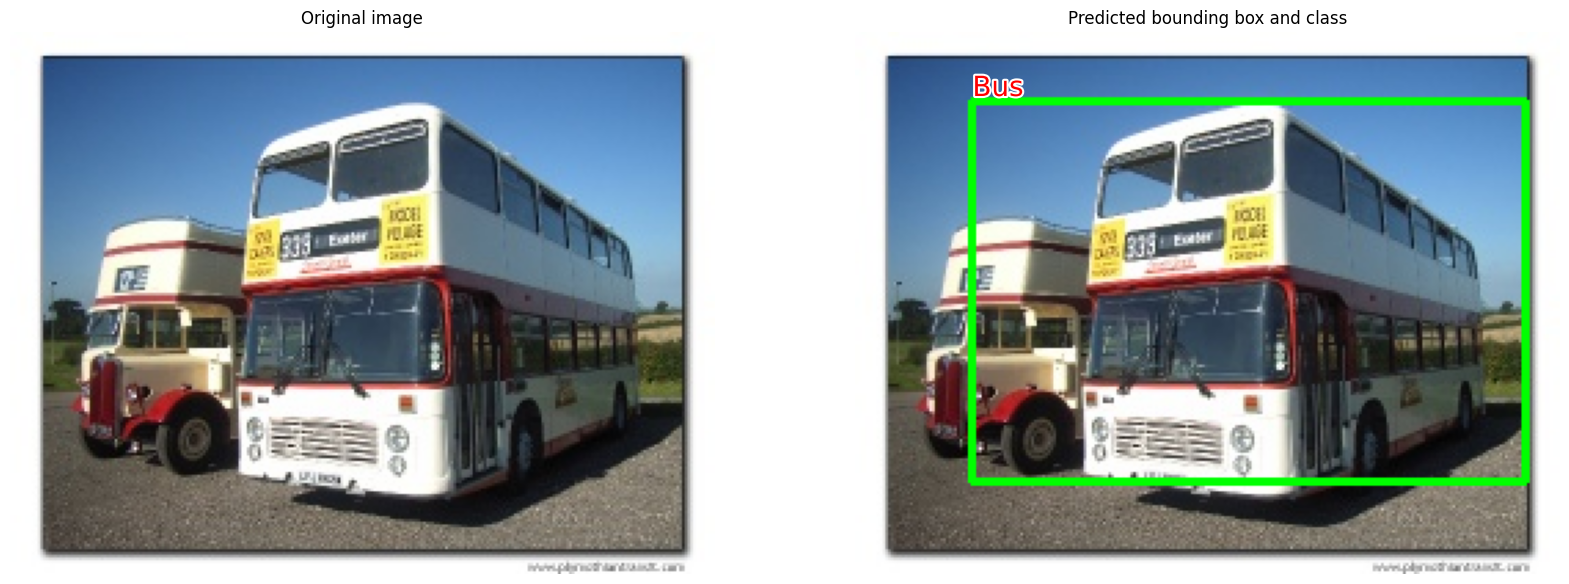

(array([ 42,  25, 243, 163], dtype=uint16), 'Bus', 0.99991417)

In [26]:
# Test the model on a sample image
, file_path = val_ds[7]
test_predictions(file_path)

## Fast R-CNN-based custom object detector

<table>
    <tbody>
        <tr>
            <td>
                <img src="fast_r-cnn.png" alt="Fast R-CNN" height="300">
            </td>
        </tr>
    </tbody>
</table>

In [37]:
# Create Dataset class for Fast Region-based Convolutional Neural Network (Fast R-CNN)
class FRCNNDataset(Dataset):
    def __init__(self, file_paths, rois, labels, deltas, gt_bbs):
        self.file_paths = file_paths
        self.gt_bbs = gt_bbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = str(self.file_paths[idx])
        image = read(file_path, 1)
        gt_bbs = self.gt_bbs[idx]
        rois = self.rois[idx]
        labels = self.labels[idx]
        deltas = self.deltas[idx]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gt_bbs, file_path

    def collate_fn(self, batch):
        images, rois, rois_idxs, labels, deltas = [], [], [], [], []
        for idx in range(len(batch)):
            image, image_rois, image_labels, image_deltas, _, _ = batch[idx]
            image = cv2.resize(image, (224, 224))
            images.append(preprocess_image(image / 255.)[None])
            rois.extend(image_rois)
            rois_idxs.extend([idx] * len(image_rois)) # Add the roi index to the list for each roi [0, 0, 0, 1, 1, 2, ...]
            labels.extend([label2target[label] for label in image_labels])
            deltas.extend(image_deltas)
        images = torch.cat(images).to(device)
        rois = torch.Tensor(np.array(rois)).float().to(device)
        rois_idxs = torch.Tensor(rois_idxs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return images, rois, rois_idxs, labels, deltas

In [38]:
# Get the train limit
n_train = 9 * len(file_paths) // 10 # 90% of the data for training

# Create the train and validation datasets
train_ds = FRCNNDataset(file_paths[:n_train], rois[:n_train], classes[:n_train], deltas[:n_train], gt_bbs[:n_train])
val_ds = FRCNNDataset(file_paths[n_train:], rois[n_train:], classes[n_train:], deltas[n_train:], gt_bbs[n_train:])

# Create a function to retrieve the dataloaders
def load_data(batch_size = 2):
    train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)
    return train_dl, val_dl

In [42]:
# Create a class for the Fast Region-based Convolutional Neural Network (Fast R-CNN) model
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the VGG16 backbone and freeze the parameters
        vgg16_bn = torchvision.models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        for param in vgg16_bn.features.parameters():
            param.requires_grad = False

        # Extract the features from the backbone until the last convolutional layer
        self.backbone = nn.Sequential(*list(vgg16_bn.features.children())[:-1])

        # Define the RoI pooling layer
        # spatial_scale is the ratio of the size of the input feature map to the size of the input image
        # image size = 224x224, input feature map size = 14x14, output feature map size = 7x7
        self.roipool = RoIPool(output_size=(7, 7), spatial_scale=14 / 224)

        # Define the output layers (head)
        feature_dim = 512 * 7 * 7 # VGG16 backbone output size
        self.class_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh(),
        )
        self.ce_loss = nn.CrossEntropyLoss()
        self.l1_loss = nn.L1Loss()
        self._lamba = 10.0 # Lambda for the regression loss

    def forward(self, images, rois, rois_idxs):
        # Extract features from the backbone
        features = self.backbone(images)

        # Convert the rois to the format [idx, x1, y1, x2, y2]
        rois = torch.cat([rois_idxs.unsqueeze(-1), rois * 224], dim=-1)

        # Apply RoI pooling and flatten the features
        features = self.roipool(features, rois)
        features = features.view(len(features), -1)

        # Get the class scores and bounding box offsets
        class_score = self.class_score(features)
        bbox = self.bbox(features)
        return class_score, bbox

    def calc_loss(self, p_labels, p_deltas, labels, deltas):
        detection_loss = self.ce_loss(p_labels, labels)
        idxs, = torch.where(labels != background_class)
        p_deltas = p_deltas[idxs]
        deltas = deltas[idxs]
        if len(idxs) > 0:
            regression_loss = self.l1_loss(p_deltas, deltas)
            return detection_loss + self._lamba * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self._lamba * regression_loss, detection_loss.detach(), regression_loss

In [43]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, rois, rois_idxs, labels, deltas = data
    p_labels, p_deltas = model(images, rois, rois_idxs)
    loss, detection_loss, regression_loss = criterion(p_labels, p_deltas, labels, deltas)
    accuracies = labels == decode_pred(p_labels)
    loss.backward()
    optimizer.step()
    return loss.detach(), detection_loss, regression_loss, accuracies.cpu().numpy()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, rois, rois_idxs, labels, deltas = data
    p_labels, p_deltas = model(images, rois, rois_idxs)
    loss, detection_loss, regression_loss = criterion(p_labels, p_deltas, labels, deltas)
    accuracies = labels == decode_pred(p_labels)
    return p_labels, p_deltas, loss.detach(), detection_loss, regression_loss, accuracies.cpu().numpy()

EPOCH: 5.000  val_loss: 4.282  val_detection_loss: 2.581  val_regression_loss: 0.170  val_acc: 0.455  (31.26s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 4143.87it/s]


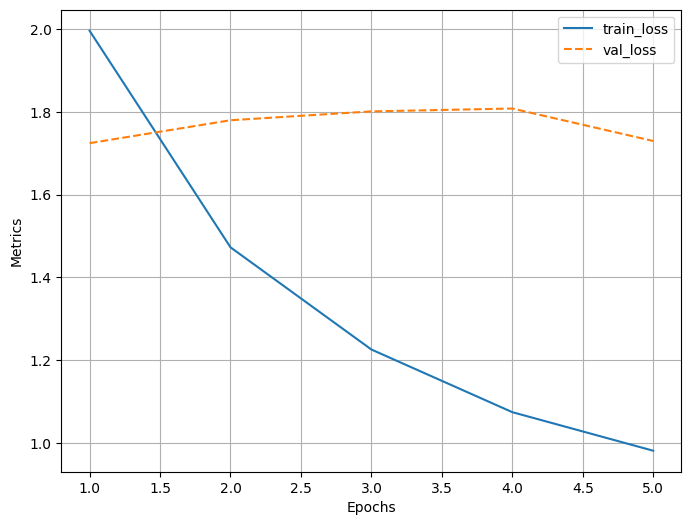

In [44]:
# Train the model
model = FRCNN().to(device)
critertion = model.calc_loss
optimizer = optim.SGD(model.parameters(), lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, detection_loss, regression_loss, accs = train_batch(model, data, critertion, optimizer)
        log.record(
            epoch+(i+1)/n,
            train_loss=loss.item(),
            train_detection_loss=detection_loss,
            train_regression_loss=regression_loss,
            train_acc=accs.mean(),
            end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        p_labels, p_deltas, loss, detection_loss, regression_loss, accs = validate_batch(model, data, critertion)
        log.record(
            epoch+(i+1)/n,
            val_loss=loss.item(),
            val_detection_loss=detection_loss,
            val_regression_loss=regression_loss,
            val_acc=accs.mean(),
            end='\r')
log.plot_epochs(['train_loss', 'val_loss'])

In [45]:
# Create a function to make predictions on a test image
def test_predictions(file_path):
    # Load the image and extract region proposals
    image = cv2.resize(read(file_path, 1), (224,224))
    candidates = [(x, y, x+w, y+h) for x, y, w, h in extract_candidates(image)]

    # Preprocess input image and region proposals
    _input = preprocess_image(image/255.)[None] # Preprocess the input image
    rois = np.array(candidates) / 224 # Normalize the region proposals by the image size
    rois_idxs = np.array([0] * len(rois)) # All region proposals are from the same image
    rois, rois_idxs = [torch.Tensor(item).to(device) for item in [rois, rois_idxs]] # Convert the region proposals and indices to tensors

    # Predict the class and bounding box offsets
    with torch.no_grad():
        model.eval()
        p_labels, p_deltas = model(_input, rois, rois_idxs)
        confidences, classes = torch.max(p_labels, -1)
    candidates = np.array(candidates)

    # Copy the tensors to the CPU and convert them to numpy arrays
    confidences, classes, p_labels, p_deltas = [tensor.detach().cpu().numpy() for tensor in [confidences, classes, p_labels, p_deltas]]
    # Get the indices of non-background classes
    idxs = classes != background_class
    # Filter the tensors by the non-background indices
    confidences, classes, p_labels, p_deltas, candidates = [tensor[idxs] for tensor in [confidences, classes, p_labels, p_deltas, np.array(candidates)]]
    # Get the bounding boxes by adding the offsets to the region proposals
    bbs = (candidates + p_deltas).astype(np.uint16)

    # Apply non-maximum suppression to the bounding boxes to remove low confidence and overlapping boxes
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confidences), 0.05)
    confidences, classes, p_labels, p_deltas, candidates, bbs = [tensor[idxs] for tensor in [confidences, classes, p_labels, p_deltas, candidates, bbs]]
    if len(idxs) == 1:
        confidences, classes, p_labels, p_deltas, candidates, bbs = [tensor[None] for tensor in [confidences, classes, p_labels, p_deltas, candidates, bbs]]

    # Display the original image and the predicted bounding box and class
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(image, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confidences) == 0:
        ax[1].imshow(image)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(image, bbs=bbs.tolist(), texts=[target2label[cl] for cl in classes.tolist()], ax=ax[1], title='Predicted bounding box and class', text_sz=20, sz=10)
        plt.show()

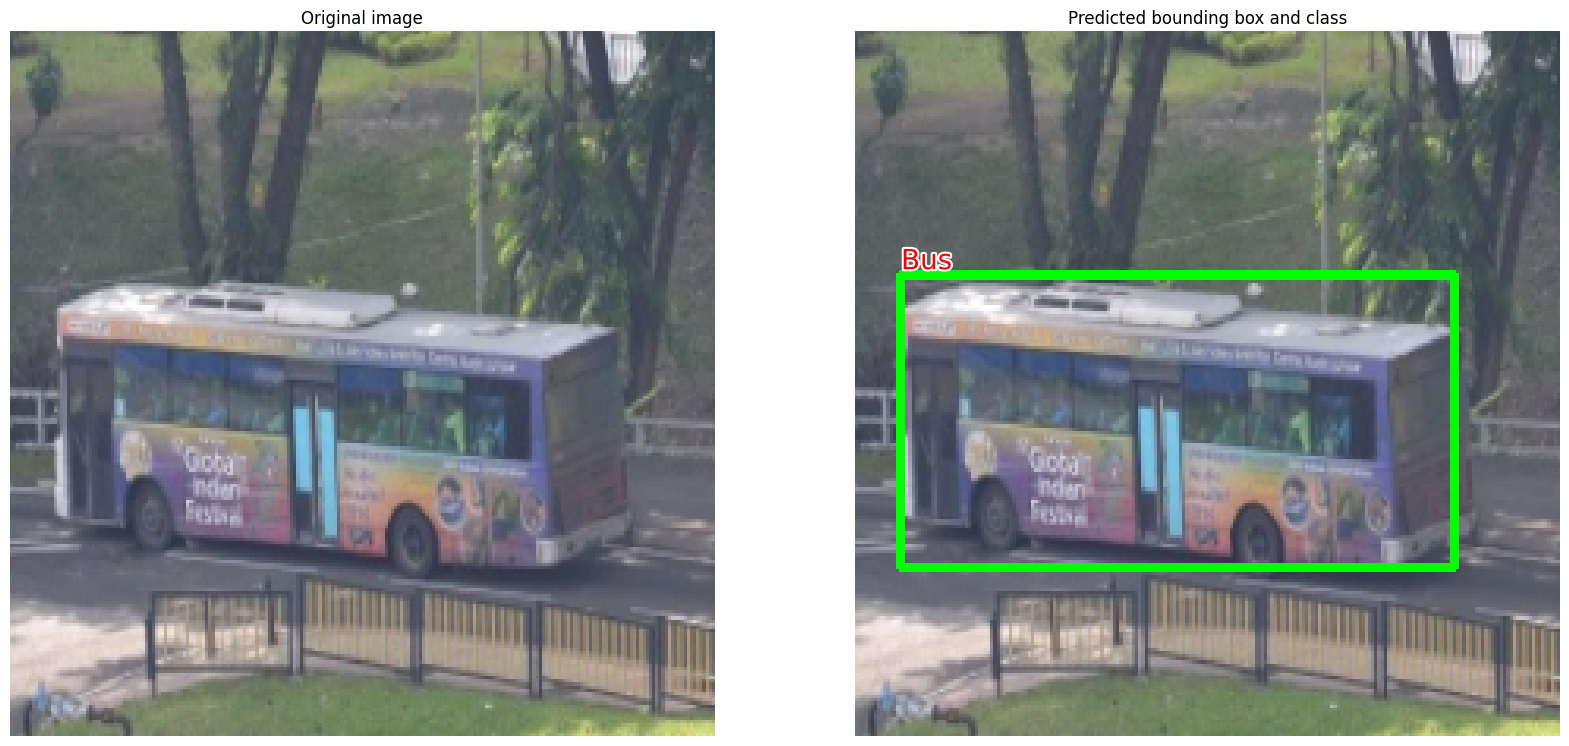

In [52]:
# Test the model on a sample image
test_predictions(val_ds[7][-1])